In [1]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name, dt):
    v = numpy.loadtxt(file_name)

    #u = numpy.array(v[:, 1:3])
    u = numpy.array(v[:, 3:5])
    x = numpy.array(v[:, 5:7])

    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x):   
    #zero initial conditions
    x_aug = x - x[0]

    vel = difference(x_aug[:, 0:2])

    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()

    axis_count = 4
    if x_ref.shape[1] == 4:
        axis_count+= 2

    fig, axs = plt.subplots(axis_count, 1, figsize=(8, 2*5))


    u_result*= 60.0/(2.0*numpy.pi)


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control forward")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control turn")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [mm]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1]*180.0/numpy.pi, color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1]*180.0/numpy.pi, color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [deg]")
    axs[3].grid()


    if axis_count == 6:
        axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2], label="ground truth", color="red")
        axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2], label="prediction", color="blue")
        axs[4].set_xlabel("time [s]")
        axs[4].set_ylabel("distance velocity")
        axs[4].legend()
        axs[4].grid()

        axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3]*180.0/numpy.pi, color="red")
        axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3]*180.0/numpy.pi, color="blue")
        axs[5].set_xlabel("time [s]")
        axs[5].set_ylabel("angle velocity")
        axs[5].grid()
        
    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [2]:
#obtain model
dt = 1.0/250.0
u_result, x_result, t_result = load_from_file("./data/run_4.log", dt)


#normalise speed

x_ref = state_augmentation(x_result.copy())

    


#identification
#a_est, b_est = LibsControl.rls_identification(u_result, x_ref)
a_est, b_est = LibsControl.krls_identification(u_result, x_ref)


c_est = numpy.eye(a_est.shape[0])
    


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")
print("poles = \n")
print(numpy.linalg.eigvals(a_est))


#symmetrise model (optional) - fix imperfection in identification
a_est[0, 0] = 1.0
a_est[1, 1] = 1.0
#a_est[numpy.abs(a_est) < 10**-3] = 0.0


print("symmetrised model\n")
print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")

n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]


mat_a = 
 [[ 9.99953900e-01 -9.14109214e-04  6.28150617e-01  1.55748836e+00]
 [ 6.58192668e-08  9.99881780e-01 -8.24644332e-04  7.70498464e-01]
 [-4.63025086e-05 -9.09797449e-04  6.28129718e-01  1.56193598e+00]
 [ 9.12424366e-08 -1.18716407e-04 -9.05235626e-04  7.71271114e-01]] 


mat_b = 
 [[ 5.20999575 -0.54655861]
 [ 0.01161065  0.0891618 ]
 [ 5.21008925 -0.54879925]
 [ 0.01276718  0.08895179]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


poles = 

[0.63888803 0.99986897 0.9995091  0.76097041]
symmetrised model

mat_a = 
 [[ 1.00000000e+00 -9.14109214e-04  6.28150617e-01  1.55748836e+00]
 [ 6.58192668e-08  1.00000000e+00 -8.24644332e-04  7.70498464e-01]
 [-4.63025086e-05 -9.09797449e-04  6.28129718e-01  1.56193598e+00]
 [ 9.12424366e-08 -1.18716407e-04 -9.05235626e-04  7.71271114e-01]] 


mat_b = 
 [[ 5.20999575 -0.54655861]
 [ 0.01161065  0.0891618 ]
 [ 5.21008925 -0.54879925]
 [ 0.01276718  0.08895179]] 




<Figure size 640x480 with 0 Axes>

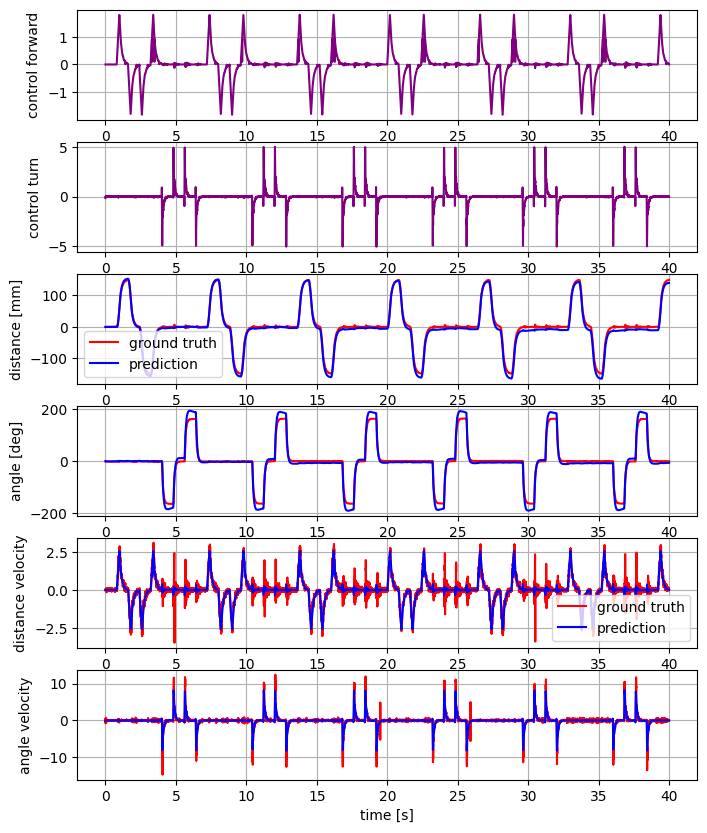

In [3]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, c_est)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)


#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 10000)


In [4]:
#controller synthetis

#create loss weighting matrices (diagonal)
#q = numpy.diag([ 10**-7, 0.5*(10**-3), 0.0, 0.0] )
#q = numpy.diag([ 10**-6, 0.5*(10**-3), 0.0, 0.0] )
q = numpy.diag([ 5*10**-6, 0.5*(10**-3), 0.0, 0.0] )
r = numpy.diag( [1.0, 1.0])  


noise_q = 0.001*numpy.eye(4)
noise_r = 0.001*numpy.diag([50.325, 0.019,  0.000, 0.000])
    

#solve LQG controller 
lqg = LibsControl.LQGDiscrete(a_est, b_est, c_est, q, r, noise_q, noise_r, 1.0)

print("controller")
print("k  = \n", lqg.k, "\n")
print("ki = \n", lqg.ki, "\n")
print("f  = \n", lqg.f, "\n")
print("\n\n")


print("poles OL = ", numpy.linalg.eigvals(a_est))
print("poles CL = ", numpy.linalg.eigvals(a_est - b_est@lqg.k))



controller
k  = 
 [[ 2.38049918e-02  2.06480282e-02  2.88694679e-02  2.60343080e-01]
 [-6.58479922e-04  4.29393303e-01 -3.71782720e-03  1.09342781e+00]] 

ki = 
 [[ 0.00252591  0.00098869  0.          0.        ]
 [-0.00010091  0.02383182  0.          0.        ]] 

f  = 
 [[ 1.31378241e-01 -1.41375757e-05 -2.65901311e-04  5.25759364e-07]
 [-5.33758447e-09  9.81689431e-01 -3.10725383e-07 -4.05452748e-08]
 [ 4.97081438e-22 -3.77909164e-22  1.00000000e+00  2.57477878e-25]
 [ 5.04392916e-25 -2.70929396e-22  1.83055038e-25  1.00000000e+00]] 




poles OL =  [0.63888802 0.99991245 0.99963014 0.76097022]
poles CL =  [0.67590852+0.14276015j 0.67590852-0.14276015j 0.81581786+0.06743622j
 0.81581786-0.06743622j]


'\nplt.plot(du_result[:, 0], label="du[0] change")\nplt.plot(du_result[:, 1], label="du[1] change")\nplt.show()\n'

<Figure size 640x480 with 0 Axes>

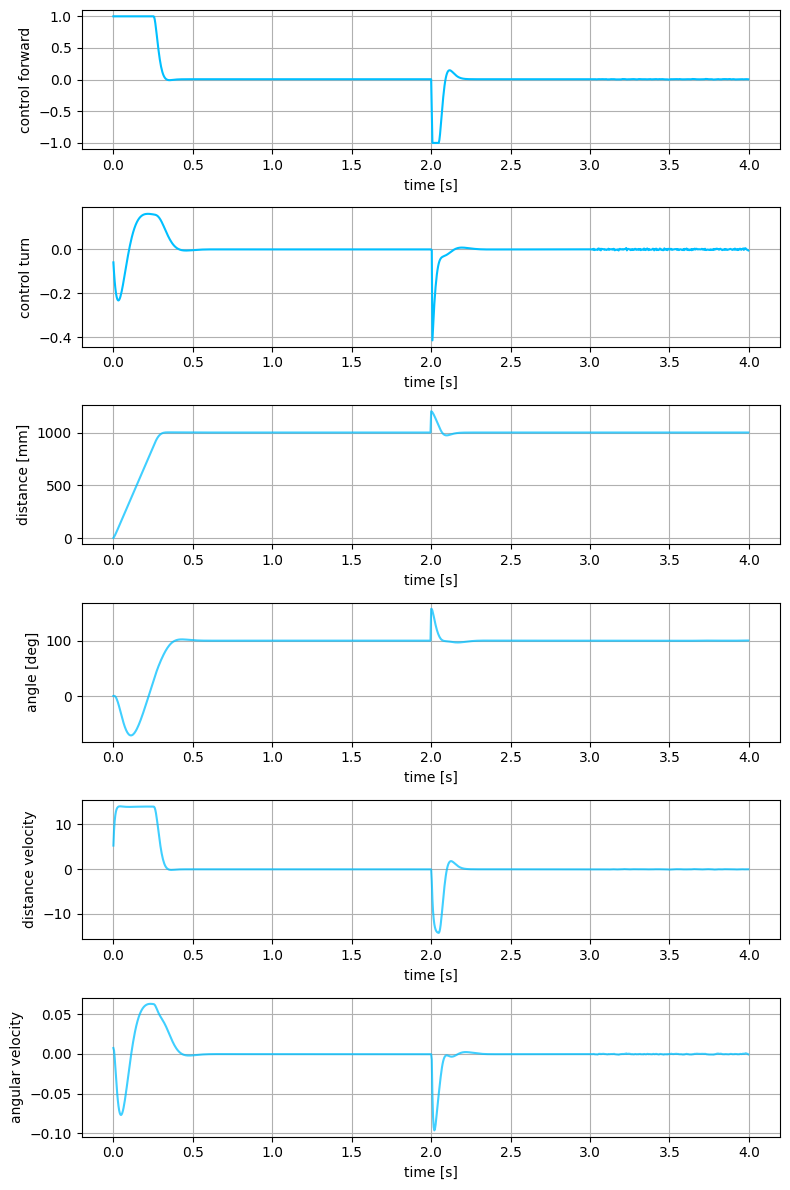

In [5]:
#process simulation

n_max = int(4.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T

#plant state
x = numpy.zeros((a_est.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

x_hat = numpy.zeros(x.shape)

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []



for n in range(n_max):

    if n > 0.75*n_max:
        noise = numpy.diagonal(noise_r)**0.5
        noise = numpy.expand_dims(noise, 1)
        x_obs = x + noise*numpy.random.randn(x.shape[0], x.shape[1])
    else:
        x_obs = x

    #compute controller output
    u, integral_action, x_hat = lqg.forward(xr, x_obs, integral_action, x_hat)

    #disturbance
    '''
    if n > n_max//2:
        u[0, :]+= 50
        u[1, :]+= 100
    '''

    if n == n_max//2:
        x[0, 0]+= 200
        x[1, 0]+= 1

    

    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)

x_result = numpy.array(x_result)

int_result = numpy.array(int_result)

du_result = x_result[1:, :] - x_result[0:-1, :]

#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_controller_output.png", u_labels = ["control forward", "control turn"], x_labels = ["distance [mm]", "angle [deg]", "distance velocity", "angular velocity"])

'''
plt.plot(du_result[:, 0], label="du[0] change")
plt.plot(du_result[:, 1], label="du[1] change")
plt.show()
'''


In [6]:
#print c-like arrays
print(matrix_to_c("a",  a_est))
print(matrix_to_c("b",  b_est))
print(matrix_to_c("c",  c_est))
print(matrix_to_c("k",  lqg.k))
print(matrix_to_c("ki", lqg.ki))
print(matrix_to_c("f",  lqg.f))




float a[] = {
		1.0, -0.00091410923, 0.62815064, 1.5574883, 
		6.5819265e-08, 1.0, -0.00082464435, 0.77049845, 
		-4.630251e-05, -0.00090979744, 0.6281297, 1.561936, 
		9.1242434e-08, -0.00011871641, -0.00090523565, 0.7712711 };

float b[] = {
		5.2099957, -0.5465586, 
		0.011610654, 0.0891618, 
		5.210089, -0.5487993, 
		0.012767176, 0.0889518 };

float c[] = {
		1.0, 0.0, 0.0, 0.0, 
		0.0, 1.0, 0.0, 0.0, 
		0.0, 0.0, 1.0, 0.0, 
		0.0, 0.0, 0.0, 1.0 };

float k[] = {
		0.023804992, 0.020648029, 0.028869469, 0.26034307, 
		-0.0006584799, 0.4293933, -0.0037178271, 1.0934278 };

float ki[] = {
		0.0025259107, 0.0009886925, 0.0, 0.0, 
		-0.0001009142, 0.02383182, 0.0, 0.0 };

float f[] = {
		0.13137825, -1.4137576e-05, -0.0002659013, 5.257594e-07, 
		-5.3375846e-09, 0.98168945, -3.1072537e-07, -4.0545274e-08, 
		0.0, 0.0, 1.0, 0.0, 
		0.0, 0.0, 0.0, 1.0 };

